In [1]:
! pip install gpytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import gpytorch
print(gpytorch.__version__)

1.5.1


In [3]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.autograd import grad
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import boda
from boda.generator import plot_tools
from boda.common import constants
from boda.common.utils import unpack_artifact, model_fn

from scipy import spatial
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
import urllib.request
from scipy.io import loadmat

lbfgs_src = '/'.join( os.getcwd().split('/')[ :os.getcwd().split('/').index('boda2') ]+['PyTorch-LBFGS/functions'] )
sys.path.insert(0, lbfgs_src)

from LBFGS import FullBatchLBFGS

In [4]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211112_154705__841131.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20211112_154705 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


In [5]:
my_model

BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [6]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
                
        hook = self.model(hook)
        
        if self.bias_cell is not None:
            hook = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                     - hook[...,self.bias_cell].mul(self.bias_alpha)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        return hook
    
    def encode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook
    
    def encode_and_decode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook, self.model.decode(hook)
    
    def encode_and_decode_and_pred(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        ec = self.model.encode(hook)
        
        dc = self.model.decode(ec)
        
        pre= self.model.classify(dc)
        
        return ec, dc, pre

In [7]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=None, bias_alpha=1.)

In [8]:
data_module = getattr(boda.data, 'MPRA_DataModule')
data = data_module(datafile_path='gs://syrgoth/data/MPRA_ALL_HD_v2.txt', data_project=['BODA','UKBB'], padded_seq_len=600)
data.setup()

cell_type = 0

--------------------------------------------------

K562 | top cut value: 11.03, bottom cut value: -6.01
HepG2 | top cut value: 10.01, bottom cut value: -5.2
SKNSH | top cut value: 10.06, bottom cut value: -5.34

Number of examples discarded from top: 0
Number of examples discarded from bottom: 0

Number of examples available: 319561

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 276121 (86.41%)
Number of examples in val:   15566 (4.87%)
Number of examples in test:  27874 (8.72%)

Excluded from train: 0 (0.0)%
--------------------------------------------------


In [9]:
print( len(data.chr_dataset_train) )
for batch in data.chr_dataset_train:
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

264680
torch.Size([4, 600])
torch.Size([3])


In [10]:
def degeneracy_filter(in_tensor, max_degeneracy=1.):
    mode_check = in_tensor.cpu() == in_tensor.cpu().mode(dim=0).values
    return torch.tensor([ val < int(max_degeneracy*mode_check.shape[0]) for val in mode_check.sum(0) ])

In [11]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.dataset_train) ]
X = X[:, :, 200:400]
Y = Y[:,cell_type]
print(X.shape)
print(Y.shape)

bsz = 128

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded, decoded, preds = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded.cpu())
        dec_.append(decoded.cpu())
        pre_.append(preds.cpu())
        
encoded = torch.cat(enc_, dim=0)
decoded = torch.cat(dec_, dim=0)
preds   = torch.cat(pre_, dim=0)
    
print(encoded.shape)
print(decoded.shape)
print(preds.shape)


torch.Size([276121, 4, 200])
torch.Size([276121])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([276121, 2600])
torch.Size([276121, 435])
torch.Size([276121, 3])


Check encoder degeneracy.
proportion equal to mode


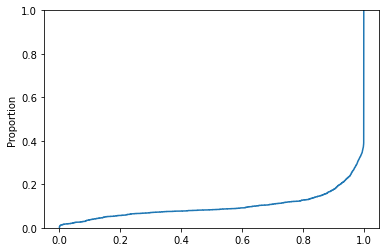

proportion different from mode


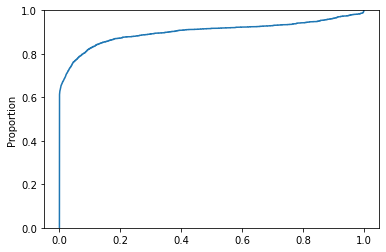

Check decoder degeneracy.
proportion equal to mode


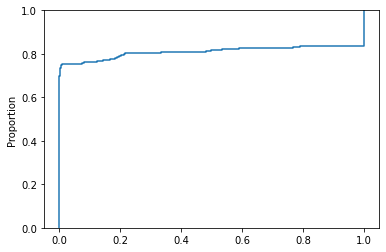

proportion different from mode


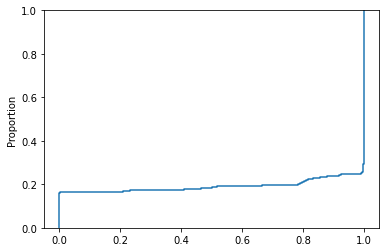

In [12]:
print("Check encoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = encoded.cpu() == encoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

print("Check decoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = decoded.cpu() == decoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

In [13]:
enc_filter = degeneracy_filter(encoded, 0.8)
print(f'encoder: {enc_filter.sum()} passed features')
dec_filter = degeneracy_filter(decoded, 0.8)
print(f'decoder: {dec_filter.sum()} passed features')

encoder: 331 passed features
decoder: 363 passed features


In [14]:
#train_x, train_y = decoded[:,dec_filter].cpu(), Y.cpu()
train_x, train_y = encoded[:,enc_filter].cpu(), Y.cpu()

In [15]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.chr_dataset_test) ]
X = X[:, :, 200:400]
Y = Y[:,cell_type]
print(X.shape)
print(Y.shape)

bsz = 128

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded_test, decoded_test, preds_test = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded_test.cpu())
        dec_.append(decoded_test.cpu())
        pre_.append(preds_test.cpu())
        
encoded_test = torch.cat(enc_, dim=0)
decoded_test = torch.cat(dec_, dim=0)
preds_test   = torch.cat(pre_, dim=0)

    
print(encoded_test.shape)
print(decoded_test.shape)
print(preds_test.shape)

torch.Size([26444, 4, 200])
torch.Size([26444])
torch.Size([26444, 2600])
torch.Size([26444, 435])
torch.Size([26444, 3])


In [16]:
#test_x, test_y = decoded_test[:,dec_filter].cpu(), Y.cpu()
test_x, test_y = encoded_test[:,enc_filter].cpu(), Y.cpu()

In [17]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))
output_device = torch.device('cuda:0')

Planning to run on 4 GPUs.


In [18]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [19]:
def train(train_x,
          train_y,
          n_devices,
          output_device,
          checkpoint_size,
          preconditioner_size,
          n_training_iter,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    model.train()
    likelihood.train()

    optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in tqdm(range(n_training_iter)):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)

            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, n_training_iter, loss.item(),
                model.covar_module.module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))

            if fail:
                print('Convergence reached!')
                break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood

In [ ]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x.cuda(), train_y.cuda(),
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

Number of devices: 4 -- Kernel partition size: 0
RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/gpytorch/kernels/kernel.py", line 398, in __call__
    res = lazify(super(Kernel, self).__call__(x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
  File "/opt/conda/lib/python3.7/site-packages/gpytorch/module.py", line 30, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/gpytorch/kernels/scale_kernel.py", line 92, in forward
    orig_output = self.base_kernel.forward(x1, x2, diag=diag, last_dim_is_batch=last_dim_is_batch, **params)
  File "/opt/conda/lib/python3.7/site-packages/gpytorch/kernels/rbf_kernel.py", line 90, in forward
    lambda x1, x2: self.covar_dist(
  File "/opt/conda/l

/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


RuntimeError: CUDA out of memory. Tried to allocate 2.22 GiB (GPU 0; 15.78 GiB total capacity; 11.71 GiB already allocated; 2.05 GiB free; 12.28 GiB reserved in total by PyTorch)
Number of devices: 4 -- Kernel partition size: 4315


  0%|          | 0/1 [00:00<?, ?it/s]/home/ubuntu/PyTorch-LBFGS/functions/LBFGS.py:257: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


In [ ]:
model, likelihood = train(train_x.cuda(), train_y.cuda(),
                          n_devices=n_devices, output_device=output_device,
                          checkpoint_size=checkpoint_size,
                          preconditioner_size=100,
                          n_training_iter=20)

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

# Plot results

In [ ]:
plt.scatter( mean.cpu().numpy(), test_y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( mean.cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), test_y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), mean.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), mean.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("GP  Predicted K562")
plt.show()

In [16]:
from sklearn.decomposition import PCA

dim_red = PCA(n_components = 3)

seq_pca = dim_red.fit_transform(encoded.cpu().numpy())
seq_pca_test = dim_red.transform(encoded_test.cpu().numpy())

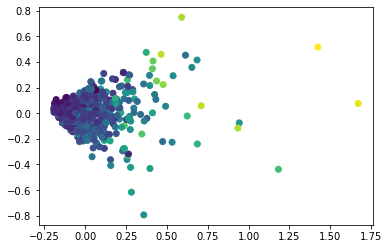

In [17]:
plt.scatter( seq_pca_test[:,0], seq_pca_test[:,1], c=Y.cpu().numpy(), cmap='viridis' )
plt.show()

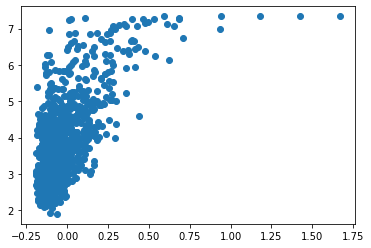

In [18]:
plt.scatter( seq_pca_test[:,0], (upper-lower).cpu().numpy() )
plt.show()

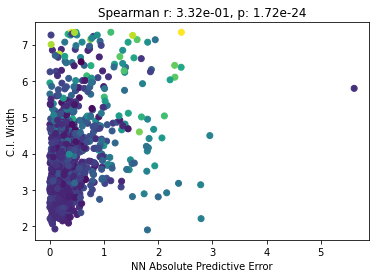

In [19]:
plt.scatter( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )
corr, pval = spearmanr( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Absolute Predictive Error")
plt.ylabel("C.I. Width")
plt.show()

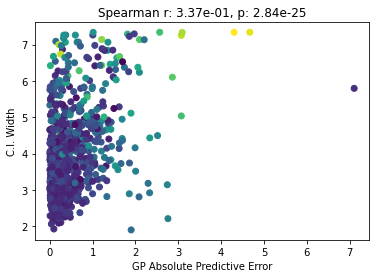

In [20]:
plt.scatter( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )

corr, pval = spearmanr( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Absolute Predictive Error")
plt.ylabel("C.I. Width")

plt.show()

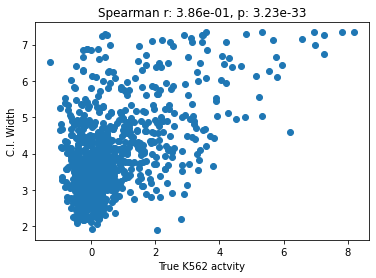

In [21]:
plt.scatter( Y.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( Y.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("True K562 actvity")
plt.ylabel("C.I. Width")
plt.show()

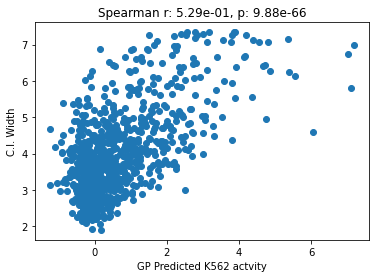

In [22]:
plt.scatter( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562 actvity")
plt.ylabel("C.I. Width")
plt.show()